In [9]:
%reset -f

In [1]:
import tensorflow as tf
import os
import random
from keras_unet_collection import models, base, utils
import numpy as np
from tqdm import tqdm 
from keras import backend as K
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import io  # for reading TIFF images
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

import time

2024-10-04 14:13:28.018229: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 14:13:28.041198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 14:13:28.041221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 14:13:28.041846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 14:13:28.045924: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the desired number of patches
desired_num_patches = 1681

# Your data directories
optic_images_dir = 'Mosaic30m_patches_128px'
sar_images_dir = 'SAR_patches_128px'
agb_maps_dir = 'AGB128Pxpatches'
fvs_images_dir = 'FVS_Patches'
slope_images_dir = 'UNET_Slope_Patches/Patches'
aspect_images_dir = 'UNET_Aspect_Patches'
# Get the list of file names in the directories without sorting
agb_map_files = os.listdir(agb_maps_dir)
optic_image_files = os.listdir(optic_images_dir)
sar_image_files = os.listdir(sar_images_dir)
fvs_image_files = os.listdir(fvs_images_dir)
slope_image_files = os.listdir(slope_images_dir)
aspect_image_files = os.listdir(aspect_images_dir)

In [3]:


# Initialize empty lists to store data
x_train_list = []
y_train_list = []
agb_values_list = []

# Loop through each patch with tqdm for progress tracking
for i in tqdm(range(min(desired_num_patches, len(optic_image_files))), desc='Loading Patches'):
    # Get file names for the current index
    optic_file = optic_image_files[i]
    sar_file = sar_image_files[i]
    agb_file = agb_map_files[i]
    fvs_file = fvs_image_files[i]
    slope_file = slope_image_files[i]  # New Slope file
    aspect_file = aspect_image_files[i]  # New Aspect file
    
    # Load images
    optic_image = io.imread(os.path.join(optic_images_dir, optic_file))
    sar_image = io.imread(os.path.join(sar_images_dir, sar_file))
    agb_map = io.imread(os.path.join(agb_maps_dir, agb_file))
    fvs_image = io.imread(os.path.join(fvs_images_dir, fvs_file))  # Load FVS image
    slope_image = io.imread(os.path.join(slope_images_dir, slope_file))  # Load Slope image
    aspect_image = io.imread(os.path.join(aspect_images_dir, aspect_file))  # Load Aspect image

    # Ensure the optic image has 13 bands
    if optic_image.shape[-1] != 13:
        raise ValueError(f"Optic image should have 13 bands. Found: {optic_image.shape[-1]}")
    
    # Ensure FVS image has 7 bands
    if fvs_image.shape[-1] != 7:
        raise ValueError(f"FVS image should have 7 bands. Found: {fvs_image.shape[-1]}")
    
    # Ensure Slope and Aspect images are 2D (single band)
    if slope_image.ndim != 2 or aspect_image.ndim != 2:
        raise ValueError("Slope and Aspect images should be 2D.")
    
    # Normalize all datasets using min-max scaling
    optic_image_normalized = (optic_image - np.min(optic_image)) / (np.max(optic_image) - np.min(optic_image))
    sar_image_normalized = (sar_image - np.min(sar_image)) / (np.max(sar_image) - np.min(sar_image))
    fvs_image_normalized = (fvs_image - np.min(fvs_image)) / (np.max(fvs_image) - np.min(fvs_image))
    slope_image_normalized = (slope_image - np.min(slope_image)) / (np.max(slope_image) - np.min(slope_image))
    aspect_image_normalized = (aspect_image - np.min(aspect_image)) / (np.max(aspect_image) - np.min(aspect_image))

    # Expand the dimensions of Slope and Aspect to match the channel structure
    slope_image_expanded = np.expand_dims(slope_image_normalized, axis=-1)
    aspect_image_expanded = np.expand_dims(aspect_image_normalized, axis=-1)

    # Concatenate optic, SAR, FVS, Slope, and Aspect images along the channel axis
    x_train = np.concatenate([optic_image_normalized, sar_image_normalized, fvs_image_normalized, slope_image_expanded, aspect_image_expanded], axis=-1)

    # Store the concatenated data
    x_train_list.append(x_train)
    agb_values_list.append(agb_map)

    # Break the loop if the desired number of patches is reached
    if len(x_train_list) >= desired_num_patches:
        break

# Combine all patches into single arrays
x_data = np.stack(x_train_list)
agb_values = np.stack(agb_values_list)

# Normalize AGB values using min-max scaling
min_agb = np.min(agb_values)
max_agb = np.max(agb_values)
agb_scaled = (agb_values - min_agb) / (max_agb - min_agb)

# Reshape scaled AGB values for compatibility with the model
agb_normalized = np.expand_dims(agb_scaled, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, agb_normalized, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

# Print the shapes of the datasets to ensure they have the correct dimensions
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val:', x_val.shape)
print('y_val:', y_val.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

input_shape = x_train.shape[1:]

Loading Patches: 100%|█████████▉| 1680/1681 [00:04<00:00, 365.70it/s]


x_train: (1075, 128, 128, 24)
y_train: (1075, 128, 128, 1)
x_val: (269, 128, 128, 24)
y_val: (269, 128, 128, 1)
x_test: (337, 128, 128, 24)
y_test: (337, 128, 128, 1)


In [4]:
model = models.swin_unet_2d((128, 128, 24), filter_num_begin=64, n_labels=1, depth=4, stack_num_down=4, stack_num_up=4, 
                            patch_size=(2, 2), num_heads=[8, 16, 16, 16], window_size=[4, 2, 2, 2], num_mlp=1024,
                            output_activation='Sigmoid', shift_window=True, name='swin_unet')

2024-10-04 14:14:35.587018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 14:14:35.606537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 14:14:35.606663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 24)]       0         []                            
                                                                                                  
 patch_extract (patch_extra  (None, 4096, 96)             0         ['input_1[0][0]']             
 ct)                                                                                              
                                                                                                  
 patch_embedding (patch_emb  (None, 4096, 64)             268352    ['patch_extract[0][0]']       
 edding)                                                                                          
                                                                                    

In [6]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-5
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [7]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=10,
                               min_lr=0.5e-6)

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [9]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_SWINUNET.h5',  monitor='val_mae' ,verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_mae'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer, lr_reducer, lr_scheduler]



start_time = time.time()

results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=4, epochs=120, callbacks=callbacks)

end_time = time.time()
training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60

print("Training completed in {:.2f} seconds ({:.2f} minutes)".format(training_time_seconds, training_time_minutes))

Learning rate:  1e-05
Epoch 1/120


2024-10-04 14:15:34.096656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-04 14:15:34.152562: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-04 14:15:34.615231: I external/local_xla/xla/service/service.cc:168] XLA service 0x797ca0823410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-04 14:15:34.615258: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-10-04 14:15:34.618029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728038734.673649  222261 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


269/269 [==============================] - ETA: 0s - loss: 0.0444 - mae: 0.1550
Epoch 1: val_mae improved from inf to 0.12923, saving model to model_for_SWINUNET.h5


/home/bagh/anaconda3/envs/tf15/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


269/269 [==============================] - 84s 186ms/step - loss: 0.0444 - mae: 0.1550 - val_loss: 0.0288 - val_mae: 0.1292 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 2/120
269/269 [==============================] - ETA: 0s - loss: 0.0184 - mae: 0.0993
Epoch 2: val_mae improved from 0.12923 to 0.09576, saving model to model_for_SWINUNET.h5
269/269 [==============================] - 48s 177ms/step - loss: 0.0184 - mae: 0.0993 - val_loss: 0.0164 - val_mae: 0.0958 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 3/120
269/269 [==============================] - ETA: 0s - loss: 0.0123 - mae: 0.0832
Epoch 3: val_mae improved from 0.09576 to 0.08649, saving model to model_for_SWINUNET.h5
269/269 [==============================] - 47s 176ms/step - loss: 0.0123 - mae: 0.0832 - val_loss: 0.0133 - val_mae: 0.0865 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 4/120
269/269 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0759
Epoch 4: val_mae improved from 0.08649 to 0.07061, saving

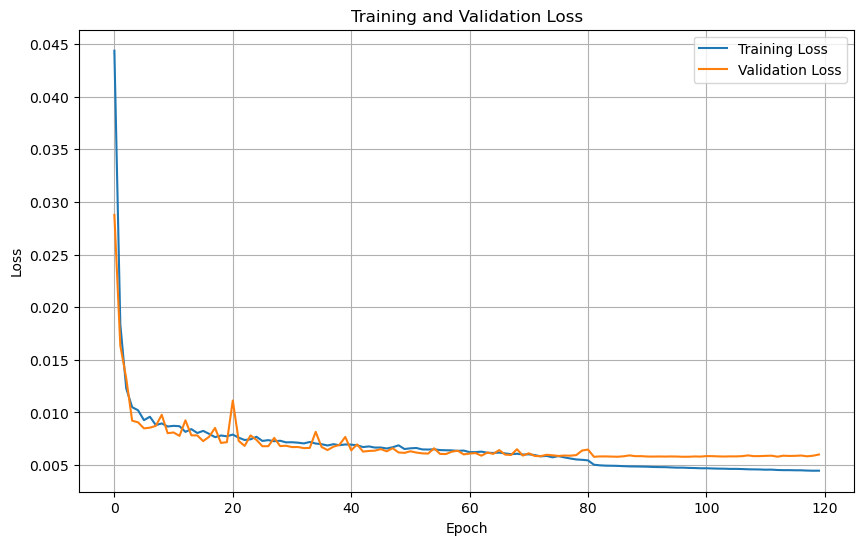

In [10]:
# Plot the loss diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('Training and Validation Loss.png', dpi=600, bbox_inches='tight')
plt.show()

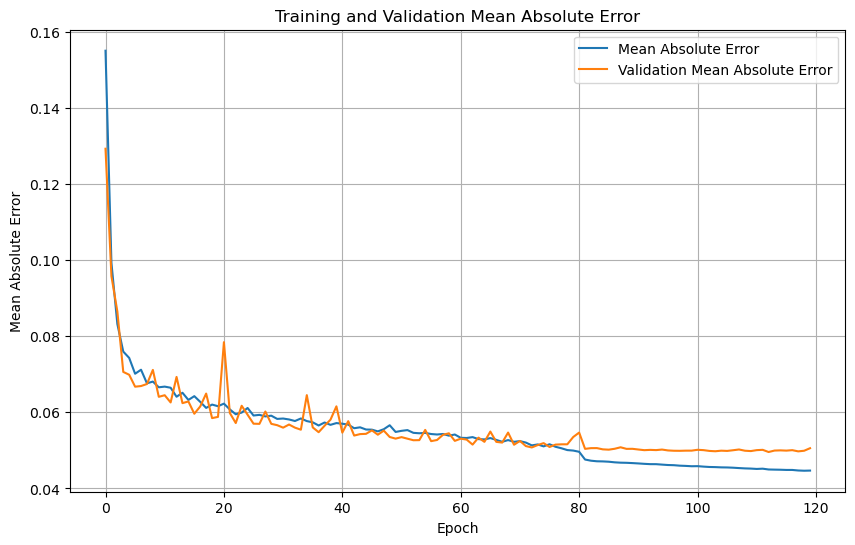

In [11]:
# Plot the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(results.history['mae'], label='Mean Absolute Error')
plt.plot(results.history['val_mae'], label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.savefig('Training and Validation Mean Absolute Error.png', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
import numpy as np
min_agb = np.min(agb_values)
max_agb = np.max(agb_values)
print(min_agb)
print(max_agb)

0
498


In [1]:
from keras.utils import custom_object_scope
from keras.models import load_model
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding, patch_merging, patch_expanding, drop_path,WindowAttention, SwinTransformerBlock  # Assuming these are part of the custom layers

# Include all custom objects that your model uses
custom_objects = {
    'patch_extract': patch_extract,
    'patch_embedding': patch_embedding,
    'patch_merging': patch_merging,
    'patch_expanding': patch_expanding,
    'drop_path': drop_path,
    'WindowAttention': WindowAttention,
    'SwinTransformerBlock': SwinTransformerBlock

    # Add other custom layers or utilities as needed
}

# Load the model using the custom scope
with custom_object_scope(custom_objects):
    
  model = load_model('model_for_SWINUNET.h5')

2024-10-06 19:33:48.218040: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 19:33:48.241362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 19:33:48.241386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 19:33:48.242120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 19:33:48.246654: I tensorflow/core/platform/cpu_feature_guar

OSError: No file or directory found at model_for_SWINUNET.h5

In [13]:
y_pred1 = model.predict(x_test)
y_pred = y_pred1 * (max_agb - min_agb) + min_agb
y_test2 = y_test * (max_agb - min_agb) + min_agb

11/11 [==============================] - 6s 326ms/step


In [14]:
# Flatten the arrays
y_test2_flat = y_test2.flatten()
y_pred_flat = y_pred.flatten()

# Calculate R^2
r2 = r2_score(y_test2_flat, y_pred_flat)

In [15]:
# Predictions on training data
y_train_pred = model.predict(x_train)
y_train_pred = y_train_pred * (max_agb - min_agb) + min_agb  # Denormalize predictions
y_train_denormalized = y_train * (max_agb - min_agb) + min_agb  # Denormalize true values

34/34 [==============================] - 16s 460ms/step


In [15]:
# Calculate R^2 for training data
y_train_pred = model.predict(x_train)
y_train_pred2 = y_train_pred * (max_agb - min_agb) + min_agb
y_train2 = y_train * (max_agb - min_agb) + min_agb
# # Flatten the arrays
y_train_pred2_flat = y_train_pred2.flatten()
y_train2_flat = y_train2.flatten()

# Calculate R^2 for training data
r2_train = r2_score(y_train2_flat, y_train_pred2_flat)

34/34 [==============================] - 12s 339ms/step


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Flatten the arrays
y_train_denormalized_flat = y_train2.flatten()
y_train_pred_flat = y_train_pred2.flatten()

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train_denormalized_flat, y_train_pred_flat))
train_mae = mean_absolute_error(y_train_denormalized_flat, y_train_pred_flat)
train_r2 = r2_score(y_train_denormalized_flat, y_train_pred_flat)

# Flatten the arrays for test data as well
y_test_denormalized_flat = y_test2.flatten()
y_test_pred_flat = y_pred.flatten()

# Calculate metrics for test data
test_rmse = np.sqrt(mean_squared_error(y_test_denormalized_flat, y_test_pred_flat))
test_mae = mean_absolute_error(y_test_denormalized_flat, y_test_pred_flat)
test_r2 = r2_score(y_test_denormalized_flat, y_test_pred_flat)

# Print or use the metrics as needed
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")



Train RMSE: 33.4385
Train MAE: 22.3209
Train R2: 0.8375
Test RMSE: 39.5372
Test MAE: 24.7822
Test R2: 0.7877


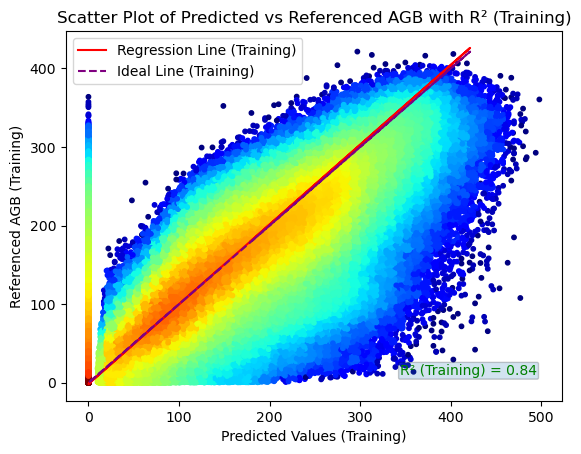

In [17]:
from matplotlib.colors import LogNorm
# Flatten the arrays
y_train_pred2_flat = y_train_denormalized_flat 
y_train2_flat = y_train_pred_flat

# Create a 2D histogram to calculate point density for training data
hist_train, x_edges_train, y_edges_train = np.histogram2d(y_train2_flat, y_train_pred2_flat, bins=(50, 50), density=True)

# Calculate the point density for each point for training data
density_train = hist_train[np.clip(np.digitize(y_train2_flat, x_edges_train) - 1, 0, hist_train.shape[0] - 1),
               np.clip(np.digitize(y_train_pred2_flat, y_edges_train) - 1, 0, hist_train.shape[1] - 1)]

# Use logarithmic scaling for density values for training data
log_density_train = np.log1p(density_train)

# Scatter plot with color based on log-scaled density for training data
scatter_train = plt.scatter(y_train_pred2_flat, y_train2_flat, c=log_density_train, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line for training data
regression_line_train = np.polyfit(y_train2_flat, y_train_pred2_flat, 1)
poly_y_train = np.polyval(regression_line_train, y_train2_flat)
plt.plot(y_train2_flat, poly_y_train, color='red', label='Regression Line (Training)')

# Plot ideal line (y = x) for training data
plt.plot(y_train2_flat, y_train2_flat, color='purple', linestyle='--', label='Ideal Line (Training)')

# Annotate R^2 value creatively for training data
annotation_text_train = f'R² (Training) = {train_r2:.2f}'
plt.annotate(annotation_text_train, xy=(0.95, 0.10), xycoords='axes fraction',
             fontsize=10, ha='right', va='top', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Add labels, legend, and colorbar for training data
plt.xlabel('Predicted Values (Training)')
plt.ylabel('Referenced AGB (Training)')
plt.title('Scatter Plot of Predicted vs Referenced AGB with R² (Training)')
plt.legend()

# Save the plot for training data as a high-quality PNG image with smaller points
plt.savefig('scatter_plot_training_data.png', dpi=600, bbox_inches='tight')

# Show the plot for training data
plt.show()

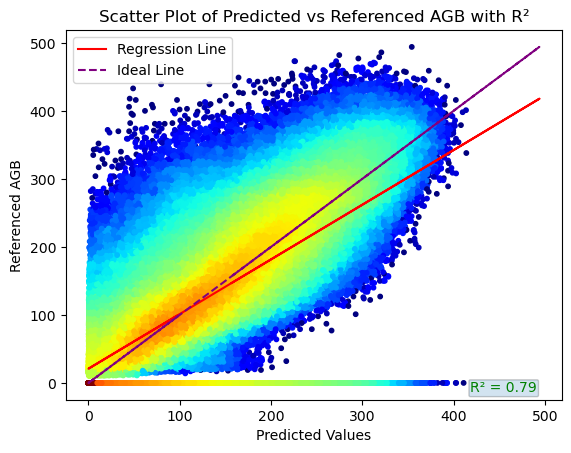

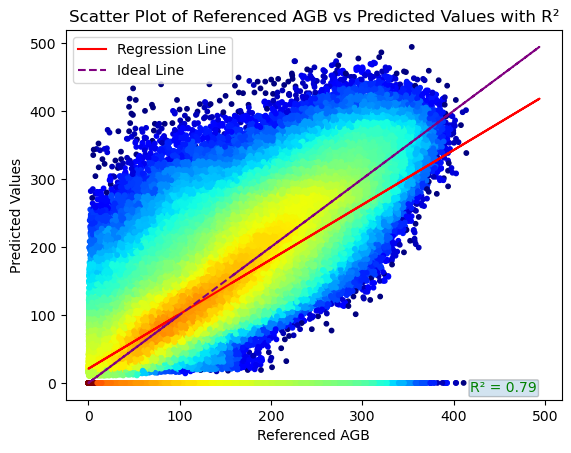

In [19]:


# Reshape arrays if needed
y_test2 = np.array(y_test2).flatten()
y_pred = np.array(y_pred).flatten()

# Create a 2D histogram to calculate point density
hist, x_edges, y_edges = np.histogram2d(y_test2, y_pred, bins=(50, 50), density=True)

# Calculate the point density for each point
density = hist[np.clip(np.digitize(y_test2, x_edges) - 1, 0, hist.shape[0] - 1),
               np.clip(np.digitize(y_pred, y_edges) - 1, 0, hist.shape[1] - 1)]

# Use logarithmic scaling for density values
log_density = np.log1p(density)

# Scatter plot with color based on log-scaled density and inverse hot colormap
scatter = plt.scatter(y_pred, y_test2, c=log_density, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line
regression_line = np.polyfit(y_test2, y_pred, 1)
poly_y = np.polyval(regression_line, y_test2)
plt.plot(y_test2, poly_y, color='red', label='Regression Line')

# Plot ideal line (y = x)
plt.plot(y_test2, y_test2, color='purple', linestyle='--', label='Ideal Line')

# Annotate R^2 value creatively
annotation_text = f'R² = {r2:.2f}'
plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=10, ha='right', va='top', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Add labels, legend, and colorbar
plt.xlabel('Predicted Values')
plt.ylabel('Referenced AGB')
plt.title('Scatter Plot of Predicted vs Referenced AGB with R²')
plt.legend()

# Save the plot as a high-quality PNG image with smaller points
plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


# Reshape arrays if needed
y_test2 = np.array(y_test2).flatten()
y_pred = np.array(y_pred).flatten()

# Create a 2D histogram to calculate point density
hist, x_edges, y_edges = np.histogram2d(y_test2, y_pred, bins=(50, 50), density=True)

# Calculate the point density for each point
density = hist[np.clip(np.digitize(y_test2, x_edges) - 1, 0, hist.shape[0] - 1),
               np.clip(np.digitize(y_pred, y_edges) - 1, 0, hist.shape[1] - 1)]

# Use logarithmic scaling for density values
log_density = np.log1p(density)

# Scatter plot with color based on log-scaled density and inverse hot colormap
scatter = plt.scatter(y_pred, y_test2, c=log_density, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line
regression_line = np.polyfit(y_test2, y_pred, 1)
poly_y = np.polyval(regression_line, y_test2)
plt.plot(y_test2, poly_y, color='red', label='Regression Line')

# Plot ideal line (y = x)
plt.plot(y_test2, y_test2, color='purple', linestyle='--', label='Ideal Line')

# Annotate R² value creatively
annotation_text = f'R² = {r2:.2f}'
plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=10, ha='right', va='top', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Add labels, legend, and colorbar
plt.xlabel('Referenced AGB')  # Changed here
plt.ylabel('Predicted Values')  # Changed here
plt.title('Scatter Plot of Referenced AGB vs Predicted Values with R²')
plt.legend()

# Save the plot as a high-quality PNG image with smaller points
plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

